# Pre-Processing Pipeline

In [3]:
#Given pseudocode to grab the .h5 data file
import numpy as np
import h5py
from scipy import signal
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

with h5py.File("data/deepclean-1251335314-4097.h5", "r") as f:
    X = []
    for channel, timeseries in f.items():
        if channel == "H1:GDS-CALIB_STRAIN":
            y = timeseries[:]
        else:
            X.append(timeseries[:])
X = np.stack(X, axis=-1) # this will do channels last (as is typically done for Keras)
print(X.shape)
print(y.shape)



(16781312, 21)
(16781312,)


## Batching

(32, 32768, 21)
(32, 32768)


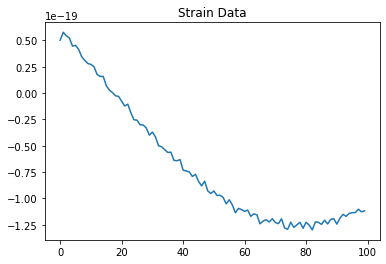

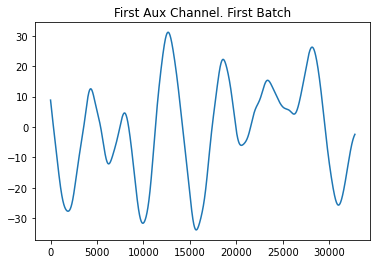

In [4]:
# then to construct inputs/outputs, you just
# slice windows from these two timeseries
window_length = 8
sample_rate = 4096
window_size = window_length * sample_rate

# sample a batch of random windows
batch_size = 32
X_batch, y_batch = [], []
for i in range(batch_size):
    idx = np.random.randint(X.shape[0] - window_size)
    X_batch.append(X[idx: idx + window_size])
    y_batch.append(y[idx: idx + window_size])

X_batch = np.stack(X_batch)
y_batch = np.stack(y_batch)

print(X_batch.shape)
print(y_batch.shape)

plt.plot(y[0:100])
plt.title("Strain Data")
plt.show()

plt.plot(X_batch[0][:,0])
plt.title("First Aux Channel. First Batch")
plt.show()




strain_data = y_batch
witness_data = X_batch
channels = 21


## Pre-processing data structure:

1. 8th Order Butterworth: Aliasing filter to mitigate power from outside the witnessed noise frequencies;

2. StandardScalar: Unit variance, Zero mean;

3. Windowing: Divide data into smaller overlapping windows;
 * Segment Length: 8.00 Seconds;
 * 0.5 Hz => DFT of 2 Seconds;
    
4. Welches Method: 1 Second DFT overlap;

5. Training: Segment overlap [%] = 96.875

6. Testing: Segment overlap [%] = 50%

## PSD and CSD analysis

In [ ]:
# 2.0: Butterworth
print("Finding pass-band frequencies via Cross Spectral Density Analysis")
## Find band pass values per channel
for i in range(0,21):
    plt.csd(X[:,i], y, 4096, label = i)
    plt.title("CSD over Channel i and Strain")
plt.show()
print()


print("Finding pass-band frequencies via Cross Spectral Density Analysis")
## Find band pass values per channel
for i in range(0,21):
    plt.psd(X[:,i], 4096, label = i)
    plt.title("PSD over all Channels")
plt.show()
print()





print("Building Butterworth Filter")
N = 8 # order of butterworth filter
Wn = [0, 0.3] #passband [low end, high end]
filter_type = "bp"
fs = Wn[1]/2

b, a = signal.butter(N, Wn, filter_type, analog=True)
w, h = signal.freqs(b, a)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(100, color='green') # cutoff frequency
plt.show()
butter_sos = signal.butter(N, Wn, filter_type, fs , output = 'sos')
print("Butterworth filter built")


Finding pass-band frequencies via Cross Spectral Density Analysis


In [ ]:
# 2.1: Apply butter_sos to data
print("Applying Butterworth to data")
print(witness_data.shape)
plt.plot(witness_data[0][:,0])
plt.show()
for idx in range(len(witness_data)):
    for channel in range(channels):
        witness_data[idx][:, channel] = signal.sosfilt(butter_sos, witness_data[idx][:, channel])
plt.plot(witness_data[0][:,0])
plt.show()
print("Butterworth filter applied to data")

## 3: Standard Scalar (Z-score)

In [ ]:


print("Normalization in progress")

plt.plot(witness_data[0][:,0])
plt.show()

scaler = StandardScaler()
strain_data = np.reshape(strain_data, (-1,1))
scaler.fit(strain_data)
strain_data = scaler.transform(strain_data)


test_1 = scaler.transform(np.reshape(witness_data[1][:,0], (-1,1)))



plt.plot(test_1, label = "Z_score")
plt.plot(witness_data[0][:,0], label = "OG Data")
plt.legend()
plt.show()
# print(witness_data.shape)

# for idx in range(len(witness_data)):
#     for channel in range(channels):
#         reshaped_witness_data = np.reshape(witness_data[idx][:, channel], (-1,1))
#         reshaped_witness_data = scaler.transform(reshaped_witness_data)
# print(witness_data.shape)


print("Normalization Complete")

## 4: Windowing Parameters

In [ ]:
# 4: Windowing
window_length = 8
DFT_length = 2
sample_rate = 4096
window_size = window_length * sample_rate
DFT_size = DFT_length * sample_rate
overlap_percent = 0.96875



## 5: Welch's Method and DFT

In [ ]:
# 5: Welches Method
print("Applying Welch's Method")
window_type = 'hann'
nperseg_train = window_size
noverlap_train = window_size*(1-overlap_percent)
nfft = DFT_size

new_data = []
for batch in range(len(witness_data)):
    for channel in range(channels):
        new_data.append(signal.welch(witness_data[idx][:, channel], sample_rate, window = 'hann'))
        
print("Welch's Method Complete")



## API Call to send data

In [ ]:
def send_data():
    """
    new_data == processed data,
    strain_data == GW processed data
    """
    return new_data, strain_data